<a href="https://colab.research.google.com/github/eschill04/TF-binding-classification-singh-lab/blob/main/classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Preprocessing Functions</h2>


* Process data (fasta file --> ATCTG...)
* Process sequences (ATCGT.... --> 4-col matrix)
* Train validation split (divide training data into 70/30 train/val)




In [ ]:
!pip3 install biopython
from numpy.ma.core import make_mask_none
import os
import random
import torch
import pandas as pd
import numpy as np
import scipy.stats as stats
from Bio import SeqIO
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from google.colab import drive
drive.mount('/content/drive')

# Input: a sequence
# Output: an array of values for each TF

#CONSTANTS
d = 16 #number of motif detectors
m = 24 #len of motif detectors
train_sequences = []
train_data = []
test_sequences = []
test_data = []


def process_sequences(sequences):
  data = []
  key = ['A', 'C', 'G', 'T']
  for i in range(0, len(sequences)):
    label = sequences[i].id
    sequence = str(sequences[i].seq)
    char_sequence = list(sequence)
    shape = (2*m + len(char_sequence) - 2, 4)
    tensor_sequence = torch.zeros(shape)
    for i in range(0, 2*m + len(char_sequence) - 2):
      for j in range(0, 4):
        if i < (m) or i > (len(char_sequence) + m - 1):
          tensor_sequence[i][j] = 0.25
        elif char_sequence[i-m] == 'N':
          tensor_sequence[i][j] = 0.25
        elif char_sequence[i-m] == key[j]:
          tensor_sequence[i][j] = 1
        else:
          tensor_sequence[i][j] = 0
    data.append([int(label), tensor_sequence])
  return data



#PREPROCESSING METHOD
def process_data(train_data_path, test_data_path):
  train_tmp = SeqIO.parse(train_data_path, "fasta")
  test_tmp = SeqIO.parse(test_data_path, "fasta")
  for s in train_tmp:
    train_sequences.append(s)
  for s in test_tmp:
    test_sequences.append(s)

#TRAIN VALIDATIONN SPLIT METHOD
def train_val_split(data, ratio):
    train = []
    len_orig = len(data)
    while len(train) < ratio * len_orig:
        idx = random.randint(0, len(data)-1)
        train.append(data[idx])
        data.pop(idx)
    val = data
    return train, val

#RUN PREPROCESSING
path = "/content/drive/MyDrive/Colab Notebooks/Spring22/SinghLab/deepbind/"
i = 0
train_data_path = "/content/drive/MyDrive/Colab Notebooks/Spring22/SinghLab/deepbind/CTCF_K562_CTCF_-SC-15914-_Stanford/train.fa"
test_data_path = "/content/drive/MyDrive/Colab Notebooks/Spring22/SinghLab/deepbind/CTCF_K562_CTCF_-SC-15914-_Stanford/test.fa"
process_data(train_data_path, test_data_path)
tv_data = process_sequences(train_sequences)
train_data, validation_data = train_val_split(tv_data, 0.7)
test_data = process_sequences(test_sequences)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h2>Define Dataset</h2>

Instantiate datasets for all 3 preprocessed data

In [ ]:
#DEFINE CUSTOM DATASET 
class CustomDataset(Dataset):
    def __init__(self, data, data_labels, transform=None, target_transform=None):
        self.data_labels = data_labels #make preprocessing fctn -- is 2d array of id, label
        self.data = data #make preprocessing fctn -- is an array of the tensors NEED PROPER SHAPE
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        datum = torch.tensor(self.data[idx][1]) #NEED DIFF FUNCTION
        label = self.data[idx][0]
        if self.transform:
            datum = self.transform(datum)
        if self.target_transform:
            label = self.target_transform(label)
        return datum, label

#INSTANTIATE DATASETS
train_dataset = CustomDataset(train_data, train_data)
validation_dataset = CustomDataset(validation_data, train_data)
test_dataset = CustomDataset(test_data, train_data)
print(len(train_dataset))
print(len(validation_dataset))
print(len(test_dataset))

75442
32332
1000


<h2>Wrap Dataloaders</h2>

In [ ]:
#WRAP DATALOADER ITERABLE
train_dataloader = DataLoader(train_dataset, batch_size=300, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=300, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=True)

<h2>Build Model</h2>
Conv1D --> ReLU --> MaxPool1D --> Linear --> Softmax

In [ ]:
from re import M
#BUILD MODEL
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CONV LAYER
        # input 64 x n+2m-2 (n = 40, m = 24 --> 86) x 4
        self.conv1 = nn.Conv1d(4, d, m) #"one dimensional feature map using a 4 channel input"
        
        # RECTIFY LAYER
        # try leaky relu
        self.relu = nn.ReLU()

        # MAXPOOL LAYER 
        self.maxpool = nn.MaxPool1d(5) # output 64 x 16 x 12

        # NN LAYER (Note: could have hidden layer depending on which works better)
        self.linear = nn.Linear(384, 2) 

        #SOFTMAX
        #self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()

        

    def forward(self, x):
        x = x.permute(0,2,1)
        #print(x.shape)
        c = self.conv1(x)
        #print(c.shape)
        r = self.relu(c) 
        #print(r.shape)
        m = self.maxpool(r)
        #print(m.shape)
        m = m.flatten(1)
        l = self.linear(m)
        #print(l.shape)
        out = self.softmax(l)
        #print(out.shape)
        #print(out)
        return out.double()
        
model = Net()

<h2>Initialize Training/Validation Loss Arrays</h2>

In [ ]:
loss_train = []
loss_validation = []
accuracy_graph = []

<h2>Define Training and Testing Loops</h2>

In [ ]:
learning_rate = .5 #THEY USE BETWEEN .05 and .0005
batch_size = 300
epochs = 100

#Notes: specific learning momentum, weight decay, etc. still not included here (default to pytorch)
# epoch number is a guess, they use 20,000 learning steps divided into 5 4,000 step segments


# Initialize the loss function annd optimizer
loss_fn = nn.CrossEntropyLoss() # MSE is specific to PBM #Binary Cross Entropy
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) #Paper specifies SGD

#####################################
# Inside the training loop, optimization happens in three steps:
#  * Call ``optimizer.zero_grad()`` to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
#  * Backpropagate the prediction loss with a call to ``loss.backward()``. PyTorch deposits the gradients of the loss w.r.t. each parameter.
#  * Once we have our gradients, we call ``optimizer.step()`` to adjust the parameters by the gradients collected in the backward pass.


def train_loop(dataloader, model, loss_fn, optimizer, t):
    size = len(dataloader.dataset)
    loss_avg = 0.0
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        #print(pred)
        #print(X)
        #print(y)
        loss = loss_fn(pred, y)
        loss_avg += loss.item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), .001)
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            if t%50 == 0:
              print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    loss_avg /= num_batches
    loss_train.append(loss_avg)


def get_total_correct(pred, y):
  sum = 0
  for i in range(0, len(pred)):
    ans = 0
    if pred[i][1] > pred[i][0]:
      ans = 1
    if ans == y[i]:
      sum = sum + 1
  return sum

def validation_loop(dataloader, model, loss_fn, t):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            #loss_test.append(loss_fn(pred, y).item())
            correct += get_total_correct(pred, y)
    val_loss /= num_batches
    correct /= size
    accuracy_graph.append(correct)
    loss_validation.append(val_loss)
    if t%50 == 0:
      print(f"Avg loss: {val_loss:>8f} \n")
      print(f"Avg accuracy: {correct:>8f} \n")


for t in range(epochs):
    if t%50 == 0:
      print(f"Epoch {t}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, t)
    validation_loop(validation_dataloader, model, loss_fn, t)
print("Done!")

Epoch 0
-------------------------------
loss: 0.700563  [    0/75442]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


loss: 0.595593  [30000/75442]
loss: 0.540633  [60000/75442]
Avg loss: 0.511606 

Avg accuracy: 0.802270 

Epoch 50
-------------------------------
loss: 0.401487  [    0/75442]
loss: 0.386432  [30000/75442]
loss: 0.388270  [60000/75442]
Avg loss: 0.395459 

Avg accuracy: 0.915533 

Done!


<h2>Plot Training and Validation Loss</h2>

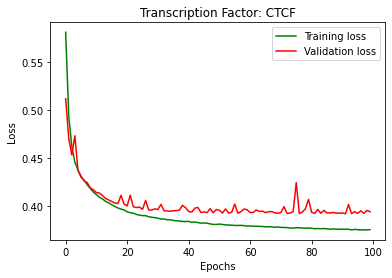

In [ ]:
import matplotlib.pyplot as plt
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
size = 100
epochs = range(0,size)
plt.plot(epochs, loss_train[0:size], 'g', label='Training loss')
plt.plot(epochs, loss_validation[0:size], 'r', label='Validation loss')
#plt.plot(epochs, accuracy_graph[0:size], 'g', label='Accuracy')
plt.title('Transcription Factor: CTCF')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<h2>Calculate Testing Accuracy</h2>

In [ ]:
#get testing accuracy
with torch.no_grad():
  correct = 0
  for X, y in test_dataloader:
    pred = model(X)
    correct += get_total_correct(pred, y)
  correct /= 1000
  print("Test accuracy:", str(100*correct) + "%")

Test accuracy: 94.89999999999999%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<h2>Save Model to Drive</h2>

In [ ]:
#save model
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_validation': loss_validation,'loss_train':loss_train
            }, '/content/drive/MyDrive/Colab Notebooks/Spring22/SinghLab/modelCTCF.pt')
